#Homework 2, Part 2
When you download the file into your Google Drive, please insert your name and student ID number here by replacing my name in the fields below. You will turn in a notebook with the coding updates and answer the questions/perform the studies in Part 9.

SeokHwan SONG   ID: 701520820


# Optimizing a Deep Neural Network

Welcome to your second assignment (part 2 of 2)! You have previously built and trained a deep Neural Network with L layers. In this part of the assignment, you will have improve the performance of the systems from Part 1. 

In this notebook, you will adapt the functions from HW 2, part 1 to optimize system performance. You will implement the following regularization and optimization methods:

*   L2 regularization (section 4)
*   Momentum (section 5)
*   Adam (section 6)

**After this assignment you will be able to:**
- Know where to change your model network to implement L2 and L1 regularization.
- Split your training data into mini-batches for improving training
- Implement momentum algorithm from RMSprop to speed up convergence

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).


## 1.0 - Mount Google Drive and import packages

In [1]:
# Mount your local google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


***Import utility files into Google Colab***
dnn_utilities.py provides unit test cases for testing the files

### 1.1 - Packages

Now, let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- Import utility files into Google Colab dnn_utilities.py provides the files to run a deep network, be sure to set the file path properly!
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed. 

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
# set filepath to dnn_utilities on your Google Drive
!cp "/content/gdrive/My Drive/Colab Notebooks/EE526HW2/HW2_2_utils_v1.py" .
from HW2_2_utils_v1 import *
# set filepath to testCases_HW2_2.py on your Google Drive
!cp "/content/gdrive/My Drive/Colab Notebooks/EE526HW2/testCases_HW2_2.py" .
from testCases_HW2_2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(1)

## 2 - Outline of the Assignment

You have been provided with a working copy of the functions that you used in part 1 of this assignment.  Here is an outline of this assignment, you will:

- Figure out which functions that will have to be changed to implement regularization, Adam Initialization, and momentum.
- Review how minibatches are implemented in the main loop of the function.
- Implement L2 regularization in the cost function and in the backwards propagation.
- Test out the effect of different values of lambda on overfitting in system performance.
- Implement momentum in the backwards propagation code.
- See if momentum speeds up training in this case.
- Implement Adam in the backwards propagation code.
- See if Adam speeds up training in this case.

Optional: what is the best system for separating dogs from non-dogs in terms of accuracy? Look at training and testing data and show that the system is not overfitting the data.



###2.1 Read in and process the data set

In [3]:
#Set path for your system
with open('/content/gdrive/My Drive/Colab Notebooks/EE526HW2/data_dog_nondog.pickle', 'rb') as handle:
    data_dict = pickle.load(handle)
#x_train, y_train, x_test, y_test = load_data(data_dict)
    x_train = data_dict['x_train']
    y_train = data_dict['y_train']
    x_test = data_dict['x_test']
    y_test = data_dict['y_test']
    x_train = x_train.T
    y_train = y_train[:,None].T
    x_test = x_test.T
    y_test = y_test[:,None].T
    

###2.2 Standardize the data

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you subtract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. This normalization helps to scale all the data into the same range. In this case, we do not have to take the mean across all features (pixels) separately as all of the variables have the same range of 0 to 255.

In [4]:
mean_x = np.mean(x_train)
std_x = np.std(x_train)
print("mean=",mean_x,"  std=",std_x)
train_set_x = (x_train-mean_x)/std_x
test_set_x = (x_test-mean_x)/std_x
print("new mean=",np.mean(train_set_x),"  new std=", np.std(train_set_x))

mean= 119.66870817057291   std= 64.03994966767696
new mean= 6.872280522429719e-17   new std= 0.9999999999999996


## 3 - Initialization and Helper Functions

You first need to review the helper functions that will initialize the parameters for your model and that compute the activation functions. These functions will generalize this initialization process to $L$ layers.


###3.1 Helper functions
As before the activation functions are provided.
```python
def sigmoid(Z):
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape   
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation

def relu(Z):
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently

def relu_backward(dA, cache):

    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
 
def sigmoid_backward(dA, cache):
    Implement the backward propagation for a single SIGMOID unit.
    
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
```

### 3.2 - L-layer Neural Network Initialization

The initialization for a deeper L-layer neural network is complicated because there are many more weight matrices and bias vectors. 
```python
def initialize_parameters_deep_he(layer_dims):
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
```


###3.3 - Forward propagation routines

The three functions are
- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)


**Linear Forward**
```python
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
 ```

**Linear -> Activation**
```python
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently


**L_Layer Model for Feedforward Step**
```python
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
 

Now you have a full forward propagation that takes the input X and outputs a row vector $A^{[L]}$ containing your predictions. It also records all intermediate values in "caches". Using $A^{[L]}$, you can compute the cost of your predictions.

###3.4 Backward propagation
Recall that with the L_model_forward function, at each iteration, you stored a cache which contains (X,W,b, and z). In the back propagation module, you  use those variables to compute the gradients. Therefore, in the L_model_backward function, you will iterate through all the hidden layers backward, starting from layer  𝐿 . On each step, you will use the cached values for layer  𝑙  to backpropagate through layer  𝑙 .

**Linear Backward**

def linear_backward(dZ, cache):

    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
    lambd -- regularization factor, if 0, no regularization

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """

**linear_activation_backward**

 """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """

**L_model_backward**

def L_model_backward(AL, Y, caches):

    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """

## 4 - L2 Regularization
In this section, you will change the pieces needed for implementing Regularization. In L2 regularization, you change the cost function to include the Frobenius Norm of the weight matrices. This is a clue as to which routines need to change implement regularization.

###4.1 - Cost function with Regularization

This code computes the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))+ \frac{\lambda}{2m}\sum\limits_{i = 1}^{L} ||W^{[l]}||_{F}^{2} \tag{1}$$


In [5]:
### Graded function

def compute_cost_regularization(AL, Y, parameters, lambd = 0):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-dog, 1 if dog), shape (1, number of examples)
    lambd -- weight for regularization, if <=0, then do not apply

    Returns:
    cost -- cross-entropy + L2 regularization cost
    """
    m = Y.shape[1] # number of inputs
    L = len(parameters) // 2
    
    assert(Y.shape == AL.shape)

    # Compute cross entropy loss from aL and y.
    cross_entropy_cost = - (1./m) * (np.dot(Y,np.log(AL).T) + np.dot(1-Y, np.log(1-AL).T))
    cross_entropy_cost = np.squeeze(cross_entropy_cost)
    
    L2_regularization_cost = 0.0

    if (lambd > 0):
      for l in range(L):
        ### enter code for computing L2 regularization
        L2_regularization_cost += lambd/(2*m) * (np.sum(np.square(parameters["W" + str(l+1)])))
        ### end code for computing L2 regularization
        
    cost = L2_regularization_cost + cross_entropy_cost

    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [6]:
AL, Y, parameters = compute_cost_regularization_test_case()
cost = compute_cost_regularization(AL, Y, parameters, lambd = 0.5)
print("cost = " + str(cost))

cost = compute_cost_regularization(AL, Y, parameters, lambd = 0.0)
print("cost no regularization = " + str(cost))

cost = 2.522423306766089
cost no regularization = 1.6025016047573226


**Expected Output**:

**cost**  2.522423306766089

**cost no regularization**  1.6025016047573226

###4.2 - Updating dW with L2 Regularization

Regularization: We will use the update_parameters routine to update the weight values under regularization. 

Exercise: Now, implement the parameters update with L2 regularization. The regularization update rule is, for l=1,...,L :
$$ W^{[l]} += \alpha dW^{[l]} + \alpha \frac{\lambda}{m} W^{[l]}\tag{2}$$
where L is the number of layers, $\alpha$ is the learning rate and $\frac{\lambda}{m}$ is the L2 rate divided by the number of input samples. All parameters should be stored in the parameters dictionary. Note that the update equation for b does not change.



In [7]:
### Graded Function

def update_parameters_with_regularization(parameters, grads, learning_rate, lambd_div_m):
    """
    Update parameters using gradient descent and regularization
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    learning_rate -- learning rate for function
    lambd_div_m -- lambda/m

    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        ### start here
        parameters["W" + str(l+1)] = (1 - learning_rate * lambd_div_m)* parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l + 1)]
        ###end here
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters


## 5 - Implementing Momentum

Just like with regularization, you will implement functions for updating backpropagarion to apply momentum. Remember that back propagation is used to calculate the gradient of the loss function with respect to the parameters. 

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable v. Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of v  as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill.

### 5.1 - initialize_momentum

**Exercise**:
Initialize the velocity. The velocity, v, is a python dictionary that needs to be initialized with arrays of zeros. Its keys are the same as those in the grads dictionary, that is: for l=1,...,L:

v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])

v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])

Note that the iterator l starts at 0 in the for loop while the first parameters are v["dW1"] and v["db1"] (that's a "one" on the superscript). This is why we are shifting l to l+1 in the for loop.

In [8]:
def initialize_momentum(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        
    return v

In [9]:
parameters = initialize_momentum_test_case()

v = initialize_momentum(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))

v["dW1"] =
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] =
[[0.]
 [0.]]
v["dW2"] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] =
[[0.]
 [0.]
 [0.]]


** Expected Output**:

v["dW1"] =
[[ 0.  0.  0.]
 [ 0.  0.  0.]]

v["db1"] =
[[ 0.]
 [ 0.]]

v["dW2"] =
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

v["db2"] =
[[ 0.]
 [ 0.]
 [ 0.]]


###5.2 Update parameters using momentum

Exercise: Now, implement the parameters update with momentum. The momentum update rule is, for  l=1,...,L :

\begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases} 

\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}

where L is the number of layers, β is the momentum and α is the learning rate. All parameters should be stored in the parameters dictionary. Note that the iterator l starts at 0 in the for loop while the first parameters are $W^{[1]}$
and $b^{[1]}$ (that's a "one" on the superscript). So you will need to shift l to l+1 when coding.

In [10]:
# GRADED FUNCTION: update_parameters_with_momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        
        ### START CODE HERE ### (approx. 4 lines)
        # compute velocities
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)] + (1-beta)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)] + (1-beta)*grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v["db" + str(l+1)]
        ### END CODE HERE ###
        
    return parameters, v

In [11]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))

W1 = 
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
[[ 1.74493465]
 [-0.76027113]]
W2 = 
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = v[[0.02344157]
 [0.16598022]
 [0.07420442]]


**Expected Output**:

```
W1 = 
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
[[ 1.74493465]
 [-0.76027113]]
W2 = 
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = v[[ 0.02344157]
 [ 0.16598022]
 [ 0.07420442]]
```

**Note**:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much. 
- Common values for $\beta$ range from 0.8 to 0.999. $\beta = 0.9$ is often a reasonable default. 
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$. 

<font color='blue'>
**Remember**

<font color='blue'>
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

##6 - Implementing Adam Initialization
Adam is one of the most effective optimization algorithms for training neural networks. It combines ideas from RMSProp (described in lecture) and Momentum.

**How does Adam work?**

1.   It calculates an exponentially weighted average of past gradients, and stores it in variables $v$(before bias correction) and $v^{corrected}$
  (with bias correction).
2.   It calculates an exponentially weighted average of the squares of the past gradients, and stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction).
3.   It updates parameters in a direction based on combining information from "1" and "2".



###6.1 Initializing Adam

Exercise: Initialize the Adam variables  $v,s$
  which keep track of the past information.

Instructions: The variables $v,s$ are python dictionaries that need to be initialized with arrays of zeros. Their keys are the same as for grads. 
```python
for l=1,...,L:
  v["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
  v["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
  s["dW" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["W" + str(l+1)])
  s["db" + str(l+1)] = ... #(numpy array of zeros with the same shape as parameters["b" + str(l+1)])
```

In [12]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
    
    return v, s

In [13]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

v["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
[[0.]
 [0.]]
v["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = 
[[0.]
 [0.]
 [0.]]
s["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
[[0.]
 [0.]]
s["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = 
[[0.]
 [0.]
 [0.]]


**Expected Output**:

```
v["dW1"] = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db1"] = 
[[ 0.]
 [ 0.]]
v["dW2"] = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db2"] = 
[[ 0.]
 [ 0.]
 [ 0.]]
s["dW1"] = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]]
s["db1"] = 
[[ 0.]
 [ 0.]]
s["dW2"] = 
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
s["db2"] = 
[[ 0.]
 [ 0.]
 [ 0.]]
```

###6.2 Update parameters using Adam.
Recall the general update rule is, for $l = 1, ..., L$: 

$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$

**Note** that the iterator `l` starts at 0 in the `for` loop while the first parameters are $W^{[1]}$ and $b^{[1]}$. You need to shift `l` to `l+1` when coding.

In [14]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads["db" + str(l+1)]
        ### END CODE HERE ###

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - beta1**t)
        ### END CODE HERE ###

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1-beta2)*grads["dW" + str(l+1)]**2
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1-beta2)*grads["db" + str(l+1)]**2
        ### END CODE HERE ###

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - beta2**t)
        ### END CODE HERE ###

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate*v_corrected["dW" + str(l+1)])/(np.sqrt(s_corrected["dW" + str(l+1)] + epsilon))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate*v_corrected["db" + str(l+1)])/(np.sqrt(s_corrected["db" + str(l+1)] + epsilon))
        ### END CODE HERE ###

    return parameters, v, s

In [15]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, v, s  = update_parameters_with_adam(parameters, grads, v, s, t = 2)

print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

W1 = 
[[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = 
[[ 1.75225313]
 [-0.75376553]]
W2 = 
[[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = 
[[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = 
[[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = 
[[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = 
[[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = 
[[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = 
[[5.49507194e-05]
 [2.75494327e-03]
 [5.50629536e-04]]


**Expected Output**:

```
W1 = 
[[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = 
[[ 1.75225313]
 [-0.75376553]]
W2 = 
[[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = 
[[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = 
[[ 0.02344157]
 [ 0.16598022]
 [ 0.07420442]]
s["dW1"] = 
[[ 0.00121136  0.00131039  0.00081287]
 [ 0.0002525   0.00081154  0.00046748]]
s["db1"] = 
[[  1.51020075e-05]
 [  8.75664434e-04]]
s["dW2"] = 
[[  7.17640232e-05   2.81276921e-04   4.78394595e-04]
 [  1.57413361e-04   4.72206320e-04   7.14372576e-04]
 [  4.50571368e-04   1.60392066e-07   1.24838242e-03]]
s["db2"] = 
[[  5.49507194e-05]
 [  2.75494327e-03]
 [  5.50629536e-04]]
```

## 7 - Putting Together the Model

You now have all the functions required for building a deep neural network with different types of optimization! We will put all these together to build an L-layer neural network to see how the network works on the dog/not dog data. Code for implementing minibatches is already included in the model.

###7.1 Mini-batch Processing
Using mini-batches can speed up training by allowing the system to learn more often. Note the permutation processing to be sure that the ordering of the data is varied for each epoch.

In [16]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X =shuffled_X[:, (k+1) * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, (k+1) * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

###7.2 The Model network

This function puts all the pieces of the model together for you so that you can try different parameter sets to optimize performance.

In [17]:
def model(X, Y, layers_dims, updater, learning_rate = 0.0075, num_epochs = 3000, 
                  lambd = 0, mini_batch_size = 0, beta = 0.9, beta1=0.9, beta2=0.999,
                   epsilon = 1e-3, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    updater -- selects type of updater to use, "gd" gradient descent, "momentum", "adam"
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_epochs -- number of iterations of the optimization loop per epoch
    lambd -- penalty term for L2 regularization
    mini_batch -- size of mini-batch, if zero, use the whole input data set
    beta -- exponential average weighting parameter for using momentum, must be between 0 and 1
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples

    # Parameters initialization. 
    parameters = initialize_parameters_deep_he(layers_dims)
    
    # Initialize the updater
    if updater == "gd":
        pass # no initialization required for gradient descent
    elif updater == "regularization":
        pass # no initialization required for regularization
    elif updater == "momentum":
        v = initialize_momentum(parameters)
    elif updater == "adam":
        v, s = initialize_adam(parameters)


    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle the dataset differently after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL, caches = L_model_forward(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost_regularization(AL, minibatch_Y, parameters, lambd)

            # Backward propagation
            grads = L_model_backward(AL, minibatch_Y, caches)

            # Update parameters
            if updater == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif updater == "regularization":
                parameters = update_parameters_with_regularization(parameters, grads, learning_rate, lambd/m)
            elif updater == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif updater == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 100 epoch
        if print_cost and i % 100 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

###7.3 Test Cases
You will now train the model as a 4-layer neural network. Once you have verified that the model is working, it will be a good time to go to the runtime menu and change the Runtime Type to GPU. It will reset your connection to your Google Drive and you will have to remount the drive. However, it will speed up your runs by quite a bit.

Run the cell below to train your model. The cost should decrease on every iteration. It may take up to 5 minutes to run 2001 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

Cost after epoch 0: 0.004462
Cost after epoch 100: 0.002258
Cost after epoch 200: 0.002026
Cost after epoch 300: 0.001869
Cost after epoch 400: 0.001727
Cost after epoch 500: 0.001594
Cost after epoch 600: 0.001460
Cost after epoch 700: 0.001324
Cost after epoch 800: 0.001189
Cost after epoch 900: 0.001058
Cost after epoch 1000: 0.000928
Cost after epoch 1100: 0.000810
Cost after epoch 1200: 0.000690
Cost after epoch 1300: 0.000592
Cost after epoch 1400: 0.000497
Cost after epoch 1500: 0.000417
Cost after epoch 1600: 0.000351
Cost after epoch 1700: 0.000296
Cost after epoch 1800: 0.000251
Cost after epoch 1900: 0.000216
Cost after epoch 2000: 0.000188


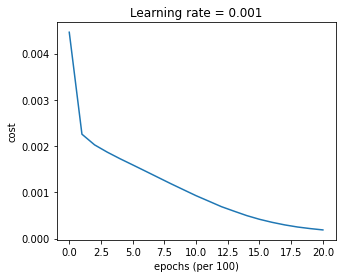

Accuracy: 0.9935000000000005
Accuracy: 0.7399999999999999


In [18]:
# Set the dimensions of each layer
layers_dims = [3072, 20, 20, 20, 1] #  4-layer model

# Use momentum to speed up training
parameters_mo = model(train_set_x, y_train, layers_dims,updater="momentum",learning_rate = 0.001, num_epochs = 2001, 
                  lambd = 0, mini_batch_size = 256, beta = 0.9, beta1=0.9, beta2=0.999,
                   epsilon = 1e-3, print_cost=True)

ptrain = predict(train_set_x, y_train,parameters_mo)
ptest = predict(test_set_x, y_test,parameters_mo)

Cost after epoch 0: 0.003434
Cost after epoch 100: 0.000154


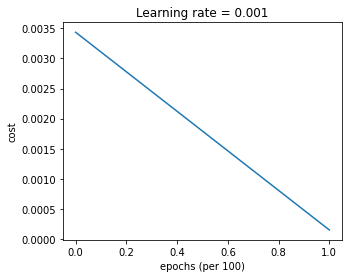

Accuracy: 0.9940000000000004
Accuracy: 0.72


In [19]:
# Use Adam to speed up training
# Note that it is only running a short time before getting perfect training set accuracy. 
#At that point it becomes numerically unstable.
parameters_ad = model(train_set_x, y_train, layers_dims,updater="adam",learning_rate = 0.001, num_epochs = 101, 
                  lambd = 0, mini_batch_size = 256, beta = 0.9, beta1=0.9, beta2=0.999,
                   epsilon = 1e-3, print_cost=True)

ptrain = predict(train_set_x, y_train,parameters_ad)
ptest = predict(test_set_x, y_test,parameters_ad)

Cost after epoch 0: 0.005337
Cost after epoch 100: 0.003230
Cost after epoch 200: 0.003005
Cost after epoch 300: 0.002851
Cost after epoch 400: 0.002709
Cost after epoch 500: 0.002579
Cost after epoch 600: 0.002447
Cost after epoch 700: 0.002320
Cost after epoch 800: 0.002184
Cost after epoch 900: 0.002058
Cost after epoch 1000: 0.001937
Cost after epoch 1100: 0.001828
Cost after epoch 1200: 0.001715
Cost after epoch 1300: 0.001625
Cost after epoch 1400: 0.001538
Cost after epoch 1500: 0.001461
Cost after epoch 1600: 0.001401
Cost after epoch 1700: 0.001350
Cost after epoch 1800: 0.001309
Cost after epoch 1900: 0.001279
Cost after epoch 2000: 0.001253


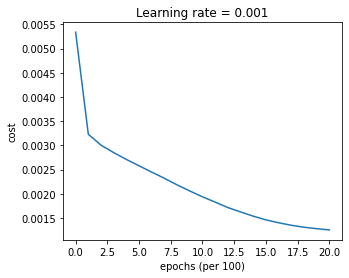

Accuracy: 0.9930000000000004
Accuracy: 0.7599999999999999


In [20]:
# Use regularization to improve overfitting
parameters_reg = model(train_set_x, y_train, layers_dims,updater="regularization",learning_rate = 0.001, num_epochs = 2001, 
                  lambd = 1, mini_batch_size = 256, beta = 0, beta1=0.9, beta2=0.999,
                   epsilon = 1e-3, print_cost=True)

ptrain_reg = predict(train_set_x, y_train,parameters_reg)
ptest_reg = predict(test_set_x, y_test,parameters_reg)


## 8 - Testing the network on dog/not dog case

Congrats on implementing all the functions required for adding in momentum, Adam and regularization into your network. We will put all these together to build an L-layer neural network to see how the network works on the dog/not dog data. Use the provided function, *print_mislabeled_images* to look at what test images were classified incorrectly.


In [21]:
def print_mislabeled_images(X, y, p, show="fp"):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    show -- string, if "fp" shows false positives, if "fn" false negatives
    """
    a = y-p
    mislabeled_indices_fn = np.asarray(np.where(a == 1))
    mislabeled_indices_fp = np.asarray(np.where(a == -1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images_fp = len(mislabeled_indices_fp[0])
    num_images_fn = len(mislabeled_indices_fn[0])
    x_test_show = X.reshape((X.shape[1],3,32,32)).transpose(0,2,3,1)
    num_images = num_images_fp
    mislabeled_indices = mislabeled_indices_fp
    if show =="fn":
      num_images = num_images_fn
      mislabeled_indices = mislabeled_indices_fn

    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x_test_show[index,:,:,:], interpolation='nearest')
        
        plt.axis('off')

    return mislabeled_indices_fn, mislabeled_indices_fp, num_images_fn, num_images_fp

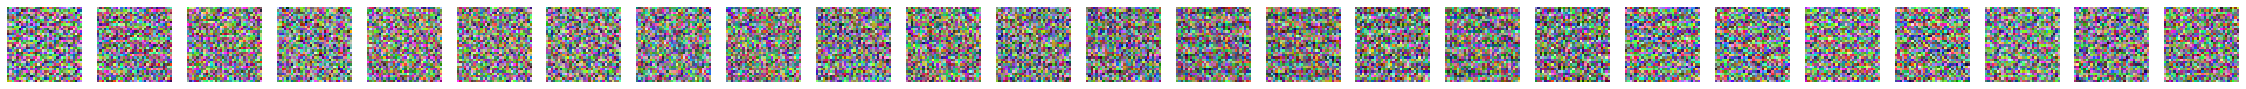

In [22]:

indices_fn, indices_fp,  num_fn, num_fp = print_mislabeled_images(x_test,y_test,ptest_reg,show ="fn")

In [23]:
print(indices_fn)
print(indices_fp)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 7 10 16 19 20 22 26 27 38 39 40 41 45 51 53 54 59 60 71 73 74 77 78 84
  87]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0]
 [101 110 112 116 117 118 120 124 131 134 136 138 139 140 141 143 150 152
  171 177 186 194 198]]


##9 Questions and other things to try

1. Given the three different options above, analyze the results and figure out if the system has a bias problem or a variance problem. Describe what strategy you might follow to improve your results.

2. Implement your strategy to see if you can improve on my results from section 7.3 with the test cases. Give a table of parameters that you tried together with the results. Run at least 5 different options. 

3. What types of test images are misclassified in your best version of the system? Do they have anything in common?




1. The accuracies of train dataset for three options are very similar but the accuracies of test dataset for three options are slightly different. With regularization it got the highest accuracy and with momentum it got the second highest accuracy and with Adam it got the lowest accuarcy.

  And the differences between train and test accuracies for all three options are big which means they all have a variance problem (high variance).

  To fix this problem, I would like to reduce the model complexity so I will reduce the number of layers to try to make it simpler and also change the size of mini batch.

In [ ]:
# Set the dimensions of each layer
layers_dims = [3072, 20, 10, 1] 

Cost after epoch 0: 0.008118
Cost after epoch 100: 0.003689
Cost after epoch 200: 0.003078
Cost after epoch 300: 0.002608
Cost after epoch 400: 0.002233
Cost after epoch 500: 0.001948
Cost after epoch 600: 0.001689
Cost after epoch 700: 0.001438
Cost after epoch 800: 0.001229
Cost after epoch 900: 0.001012
Cost after epoch 1000: 0.000859
Cost after epoch 1100: 0.000731
Cost after epoch 1200: 0.000604
Cost after epoch 1300: 0.000512
Cost after epoch 1400: 0.000430
Cost after epoch 1500: 0.000359
Cost after epoch 1600: 0.000305
Cost after epoch 1700: 0.000259
Cost after epoch 1800: 0.000224
Cost after epoch 1900: 0.000195
Cost after epoch 2000: 0.000170


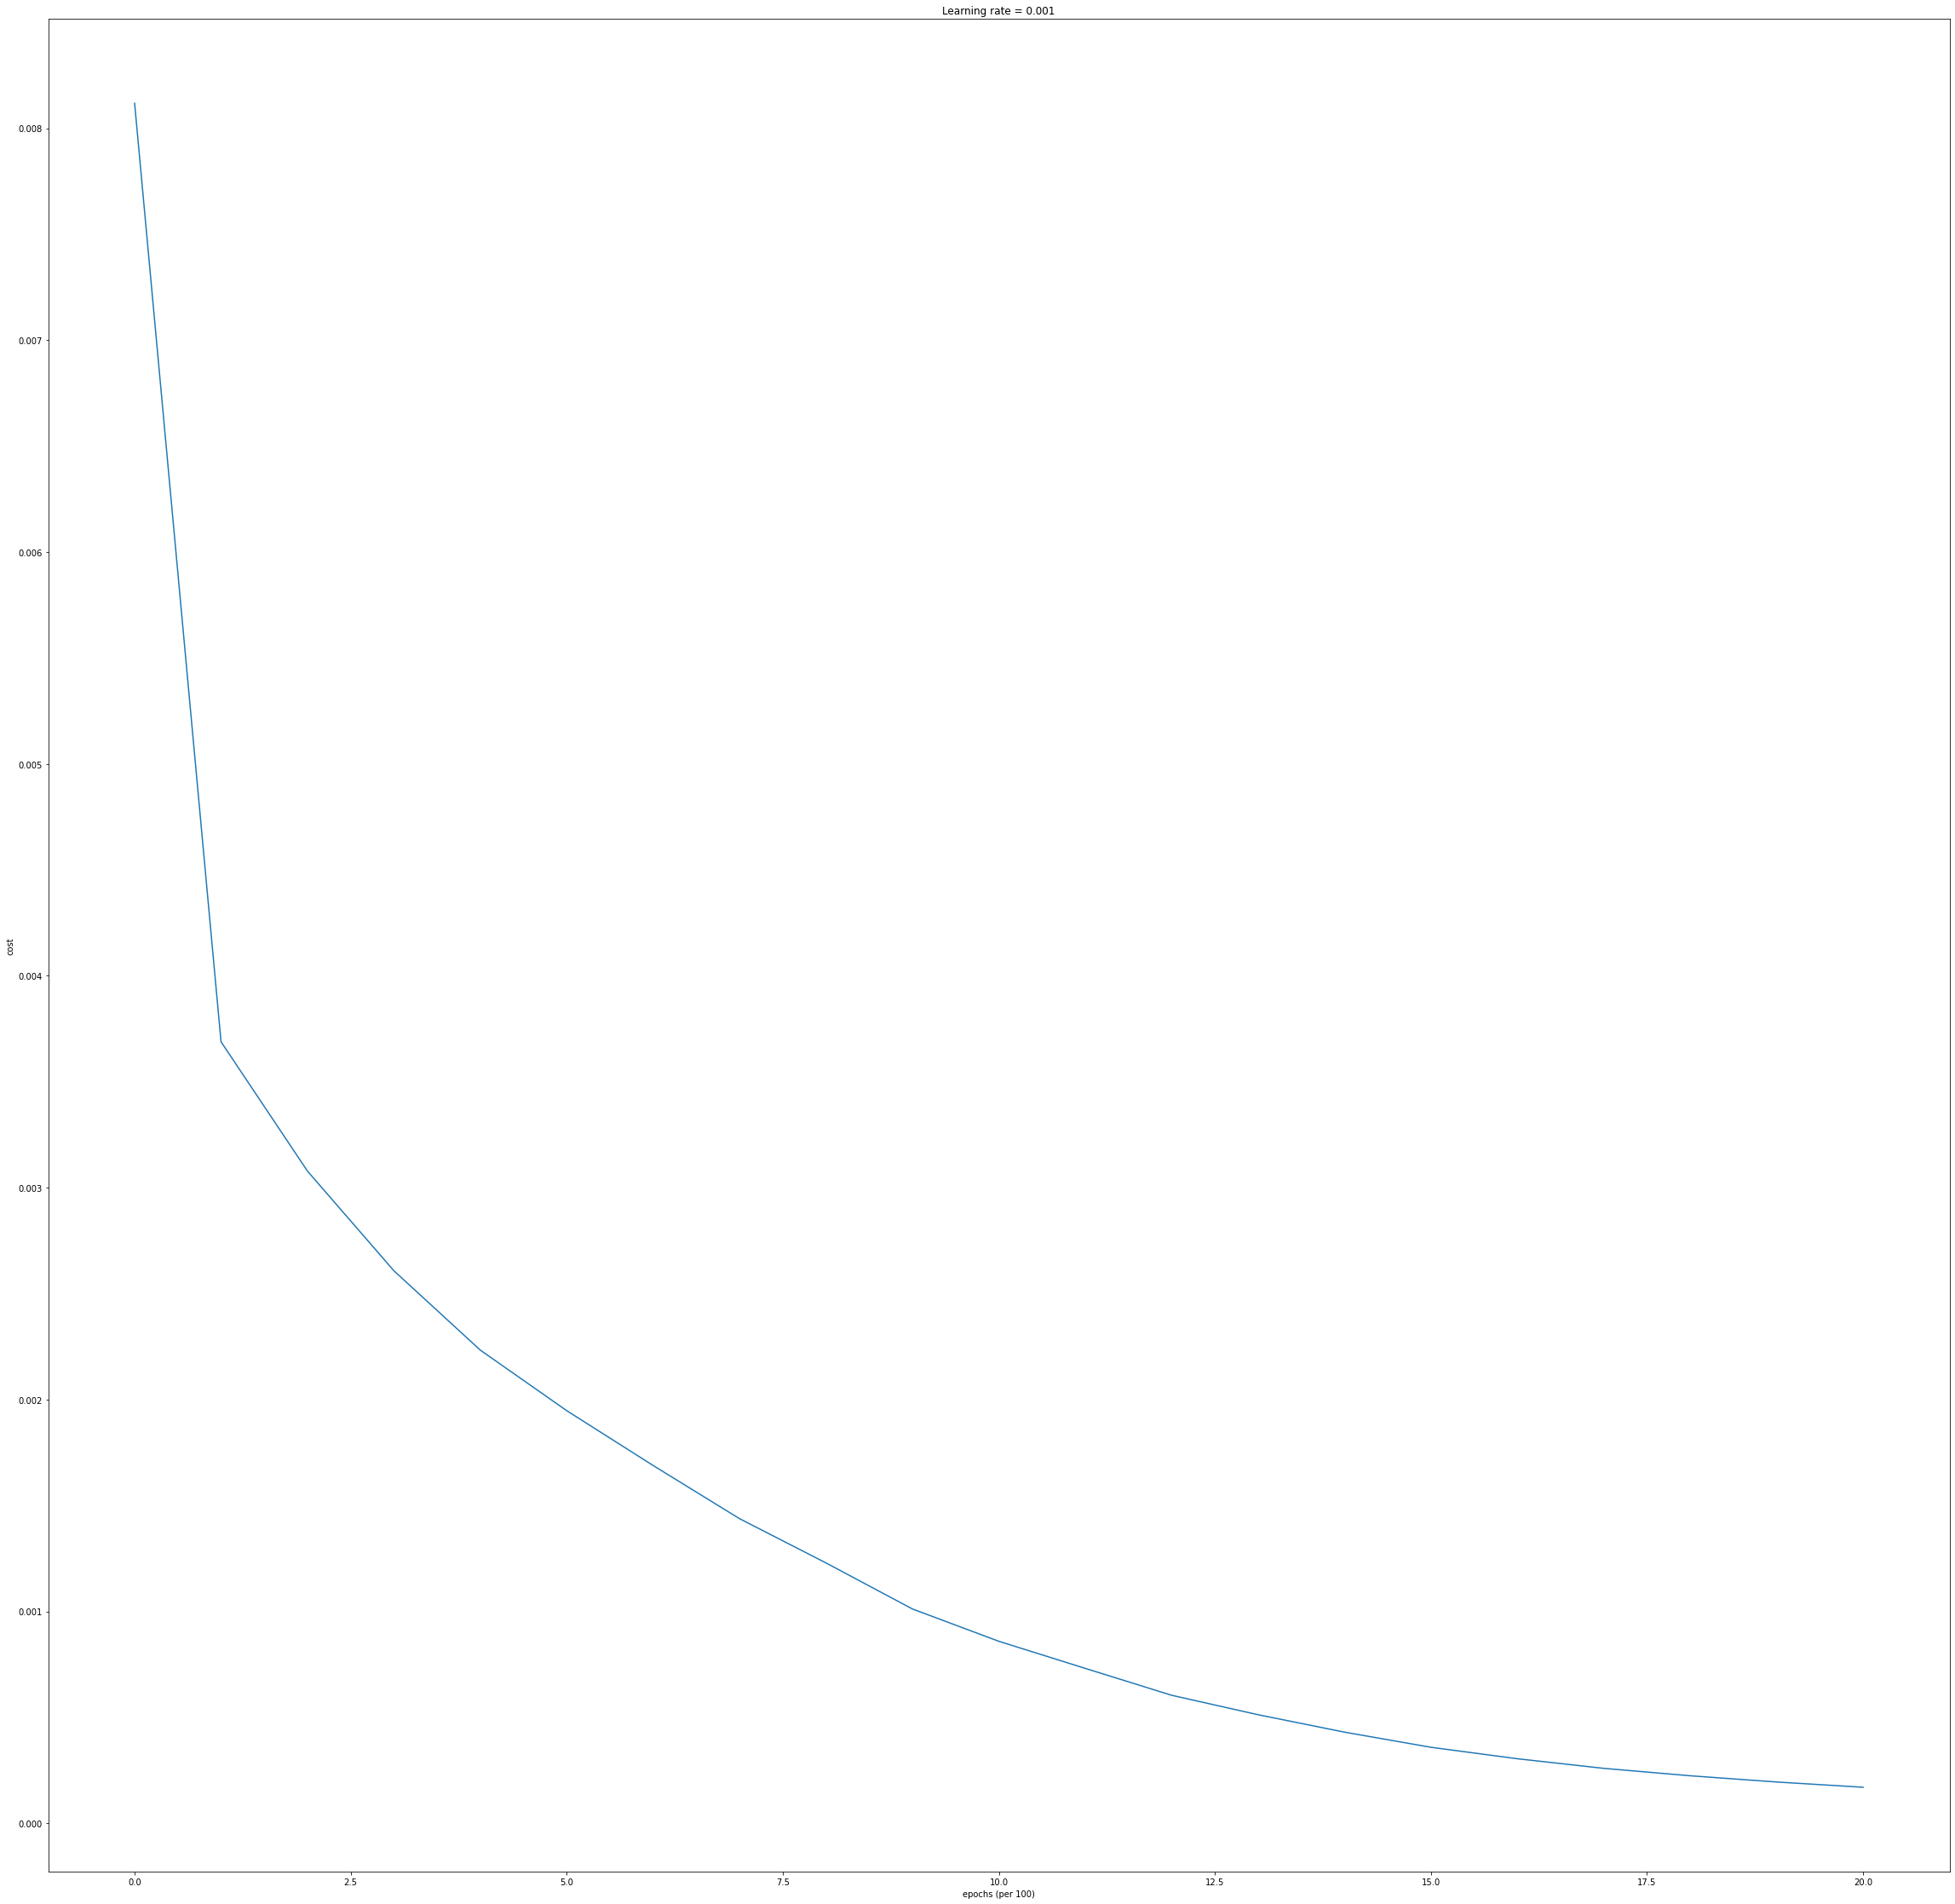

Accuracy: 0.9990000000000004
Accuracy: 0.75


In [ ]:
# Use momentum to speed up training
parameters_mo = model(train_set_x, y_train, layers_dims,updater="momentum",learning_rate = 0.001, num_epochs = 2001, 
                  lambd = 0, mini_batch_size = 128, beta = 0.9, beta1=0.9, beta2=0.999,
                   epsilon = 1e-3, print_cost=True)

ptrain = predict(train_set_x, y_train,parameters_mo)
ptest = predict(test_set_x, y_test,parameters_mo)

In [ ]:
# Set the dimensions of each layer
layers_dims = [3072, 30, 5, 1] 

Cost after epoch 0: 0.002813
Cost after epoch 100: 0.000165


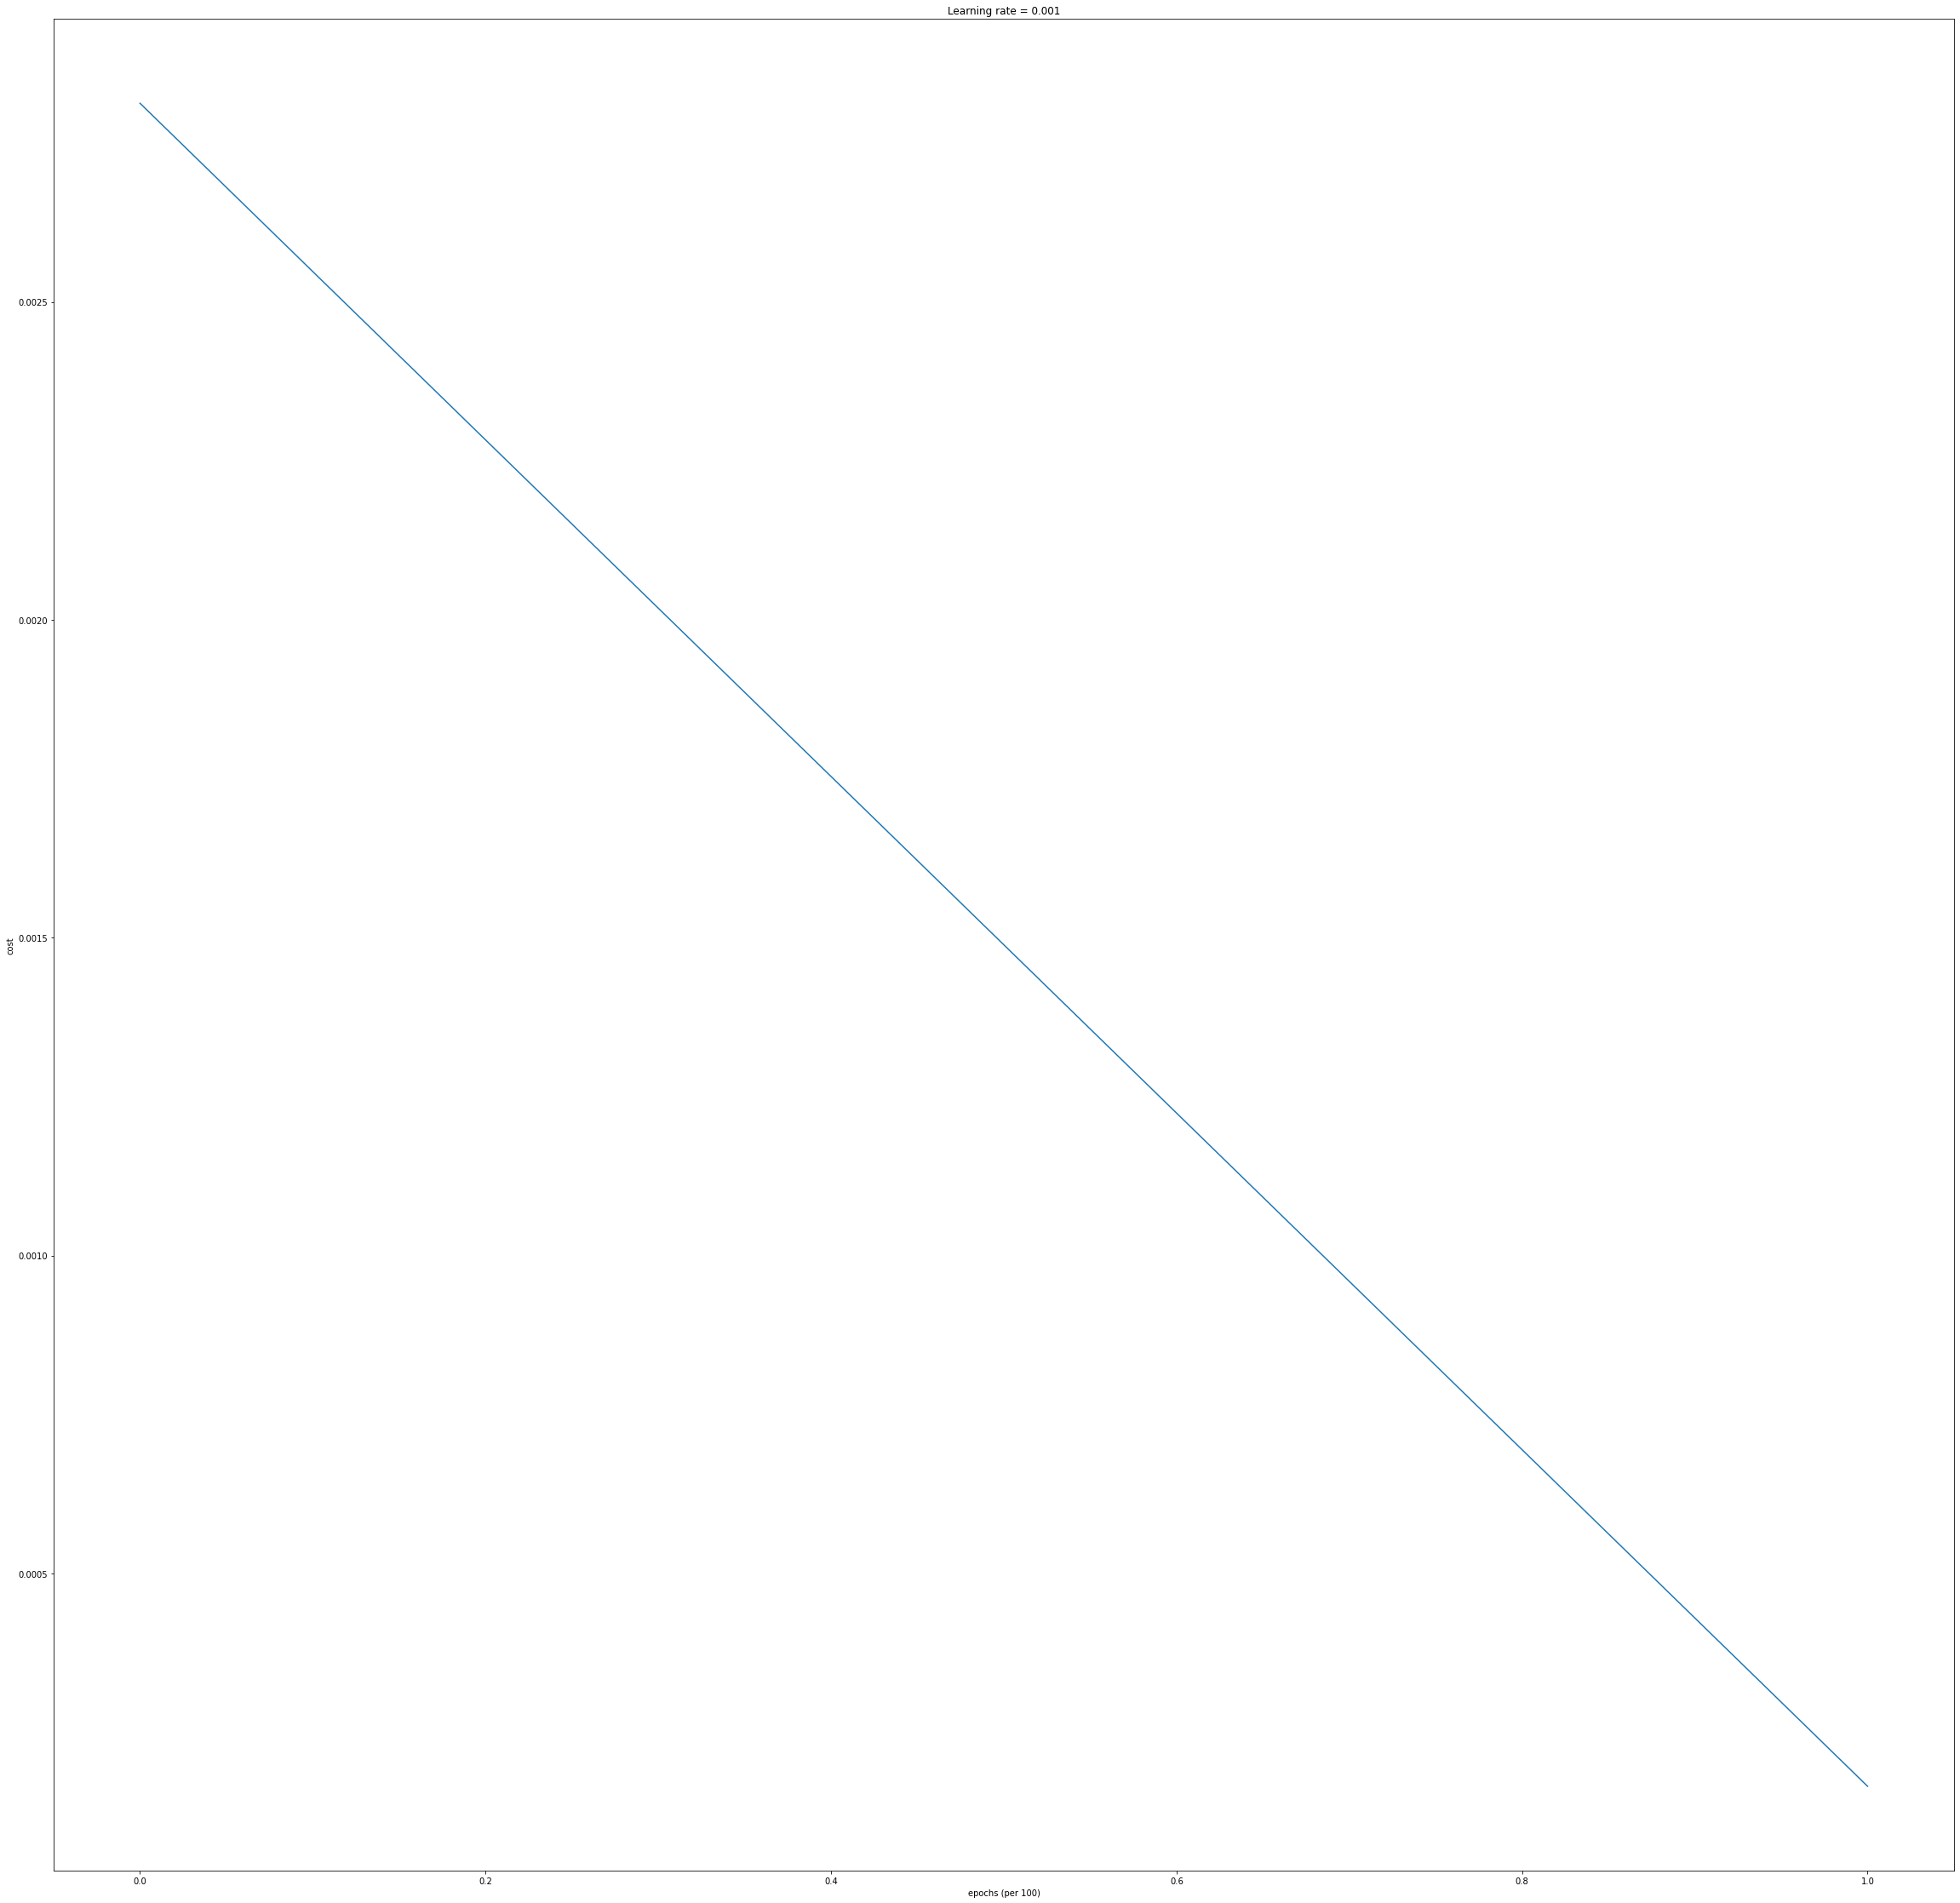

Accuracy: 0.9965000000000004
Accuracy: 0.72


In [ ]:
# Use Adam to speed up training
# Note that it is only running a short time before getting perfect training set accuracy. 
#At that point it becomes numerically unstable.
parameters_ad = model(train_set_x, y_train, layers_dims,updater="adam",learning_rate = 0.001, num_epochs = 101, 
                  lambd = 0, mini_batch_size = 256, beta = 0.9, beta1=0.9, beta2=0.999,
                   epsilon = 1e-3, print_cost=True)

ptrain = predict(train_set_x, y_train,parameters_ad)
ptest = predict(test_set_x, y_test,parameters_ad)

In [ ]:
# Set the dimensions of each layer
layers_dims = [3072, 20, 10, 1] 

Cost after epoch 0: 0.004552
Cost after epoch 100: 0.002580
Cost after epoch 200: 0.002358
Cost after epoch 300: 0.002196
Cost after epoch 400: 0.002054
Cost after epoch 500: 0.001936
Cost after epoch 600: 0.001826
Cost after epoch 700: 0.001734
Cost after epoch 800: 0.001645
Cost after epoch 900: 0.001577
Cost after epoch 1000: 0.001510
Cost after epoch 1100: 0.001450
Cost after epoch 1200: 0.001384
Cost after epoch 1300: 0.001337
Cost after epoch 1400: 0.001285
Cost after epoch 1500: 0.001231
Cost after epoch 1600: 0.001190
Cost after epoch 1700: 0.001150
Cost after epoch 1800: 0.001109
Cost after epoch 1900: 0.001078
Cost after epoch 2000: 0.001038


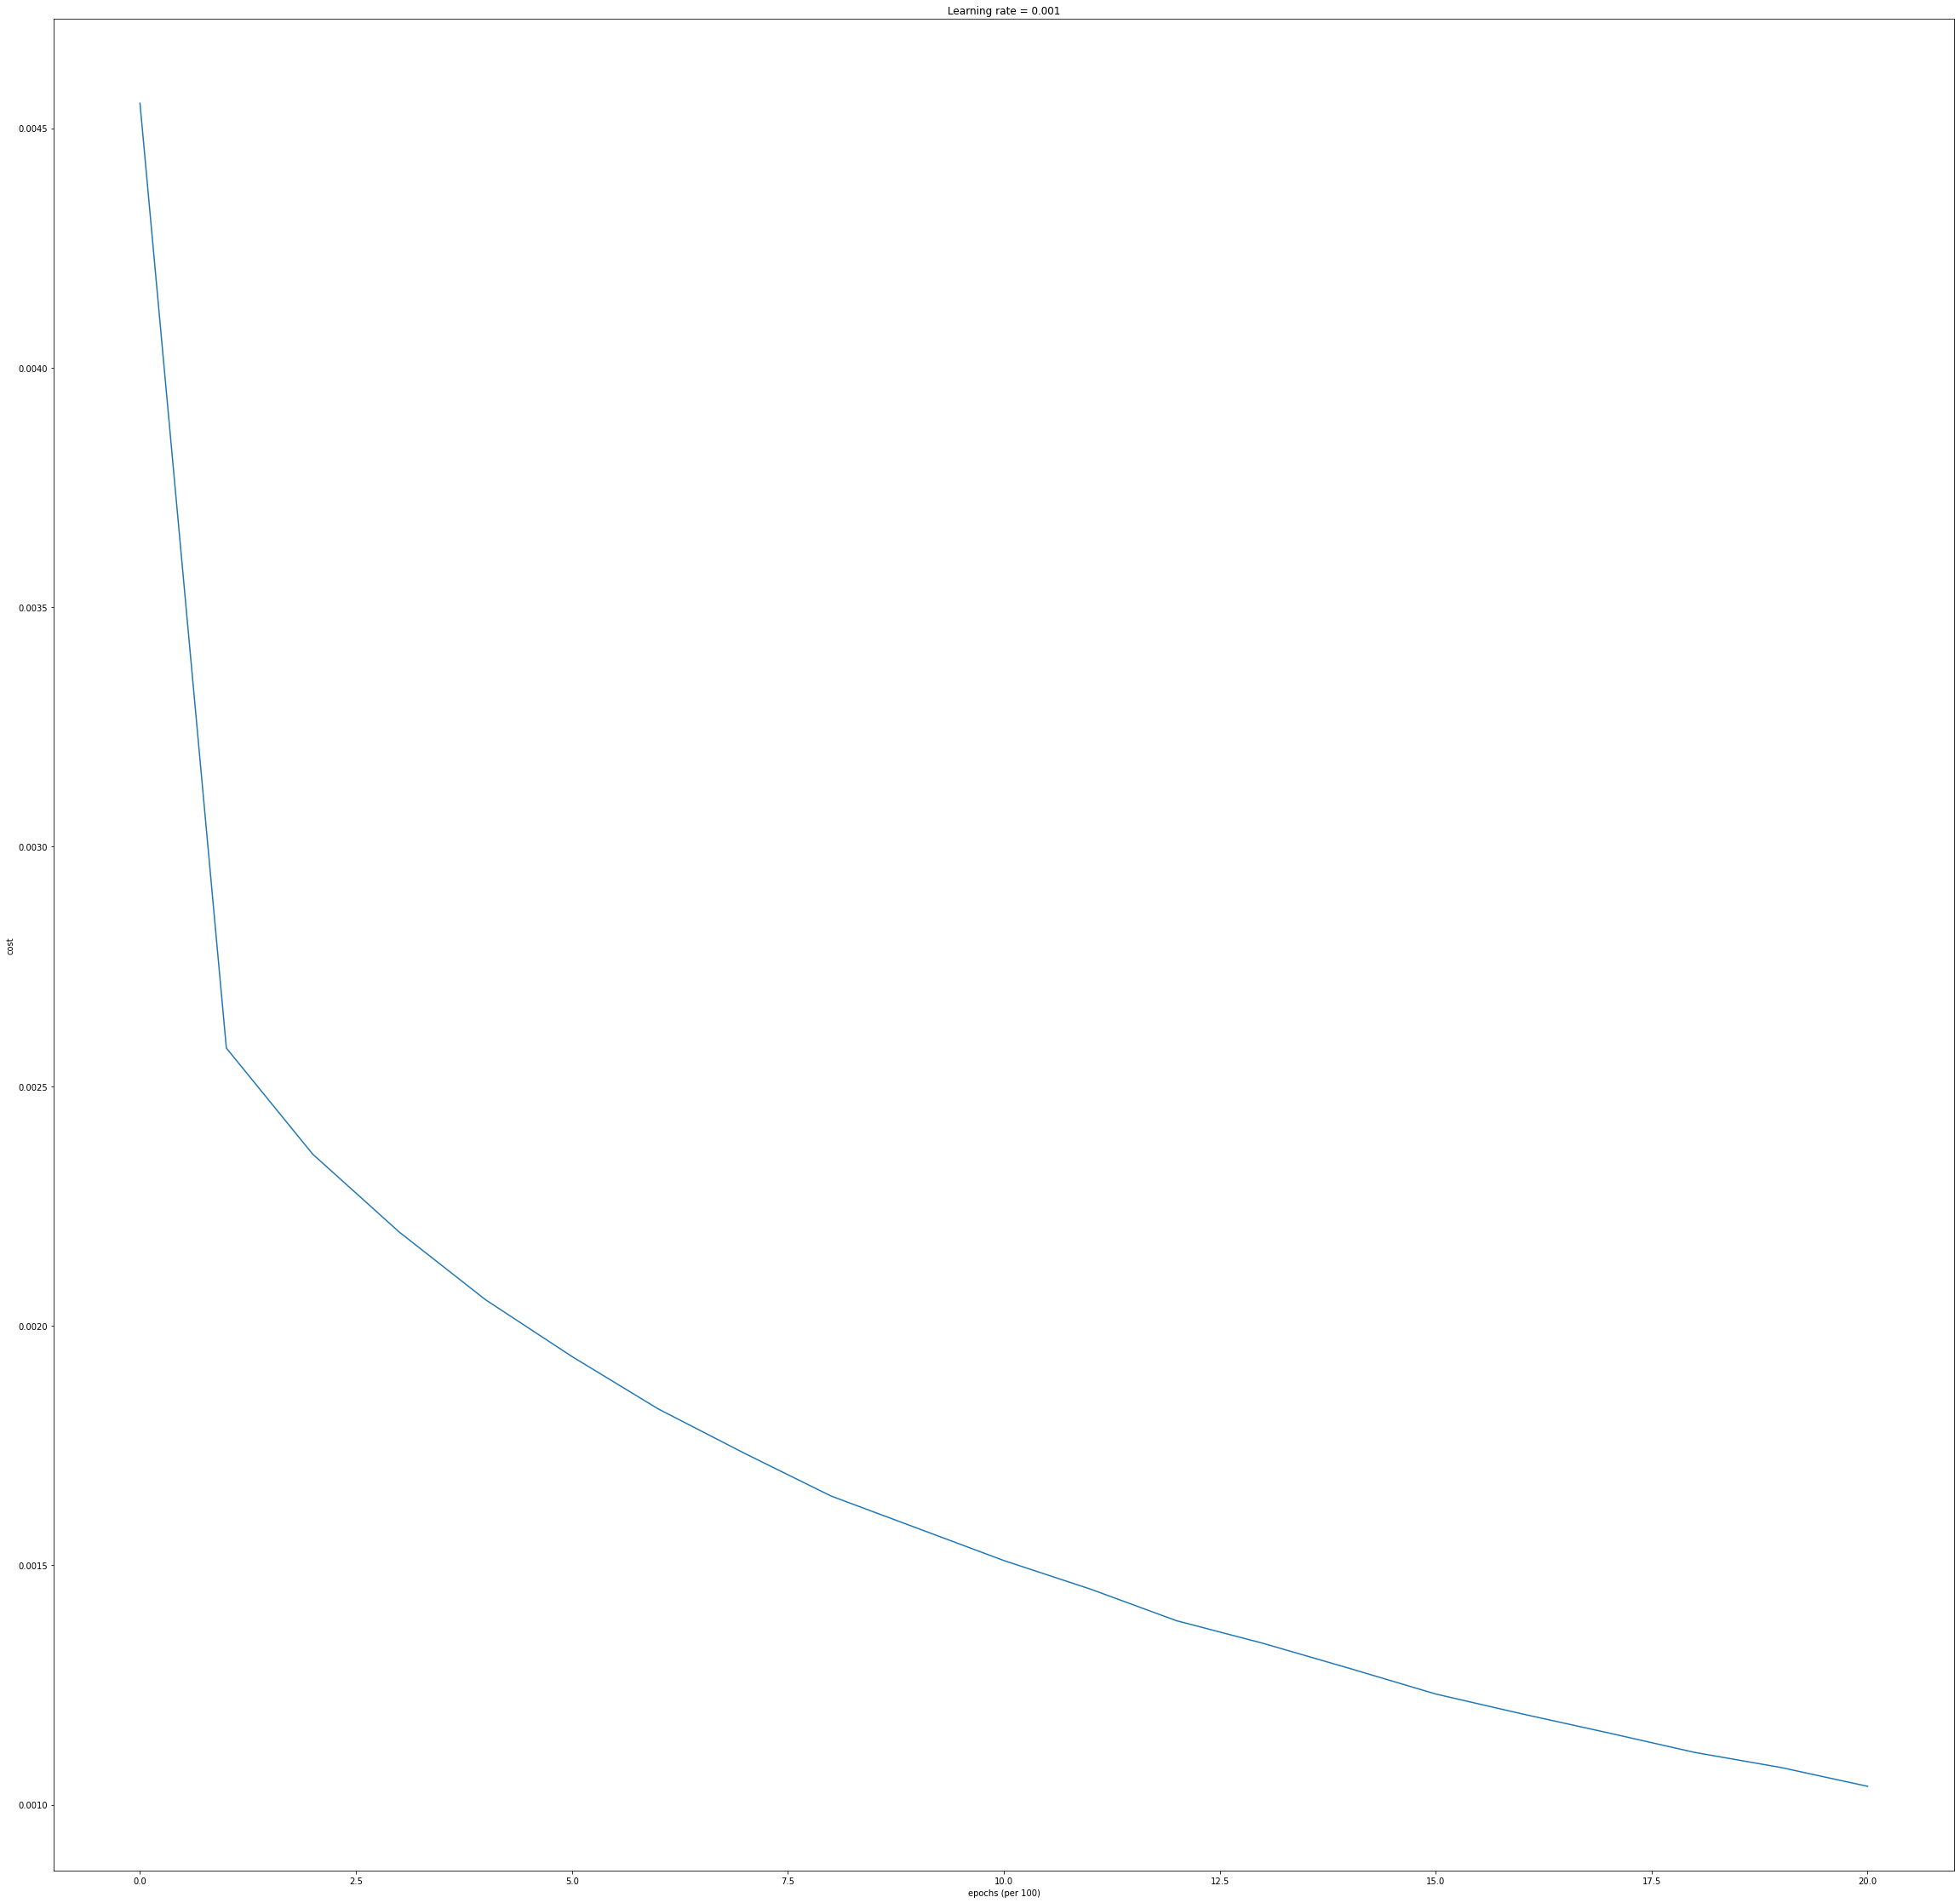

Accuracy: 0.9730000000000004
Accuracy: 0.7999999999999999


In [ ]:
# Use regularization to improve overfitting
final_parameters_reg = model(train_set_x, y_train, layers_dims,updater="regularization",learning_rate = 0.001, num_epochs = 2001, 
                  lambd = 1, mini_batch_size = 256, beta = 0, beta1=0.9, beta2=0.999,
                   epsilon = 1e-3, print_cost=True)

final_train_reg = predict(train_set_x, y_train,final_parameters_reg)
final_test_reg = predict(test_set_x, y_test,final_parameters_reg)

2. 

*   Regularization


1.  layers_dims = [3072, 20, 10, 1] / batch size = 256

  Accuracy: 0.9730000000000004
  
  Accuracy: 0.7999999999999999


*   Momentum


1.   layers_dims = [3072, 20, 10, 1] / batch size = 256

  Accuracy: 0.9740000000000004
  
  Accuracy: 0.7899999999999999

2.   layers_dims = [3072, 20, 10, 1] / batch size = 128
  
  Accuracy: 0.9990000000000004
  
  Accuracy: 0.75




*   Adam



1.   layers_dims = [3072, 20, 10, 1] / batch size = 256

  Accuracy: 0.9740000000000004
  
  Accuracy: 0.7899999999999999


2.   layers_dims = [3072, 20, 10, 1] / batch size = 128

  Accuracy: 0.9990000000000004

  Accuracy: 0.75





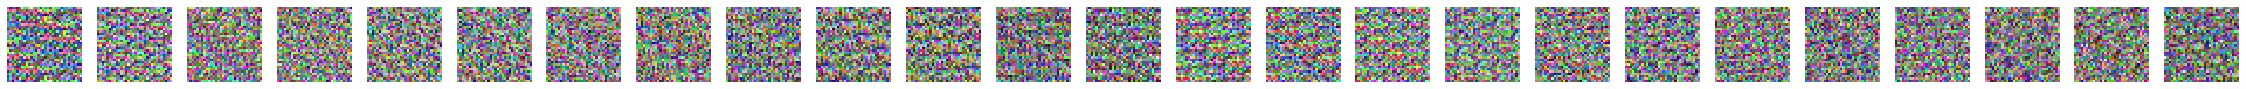

In [ ]:
final_indices_fn, final_indices_fp,  final_num_fn, final_num_fp = print_mislabeled_images(x_test,y_test,final_test_reg,show ="fn")

In [ ]:
print(final_indices_fn)
print(final_indices_fp)
print(final_num_fn)
print(final_num_fp)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 2  7 16 22 26 28 32 40 41 44 46 47 60 67 73 74 78 81 84 87 88 89 92 98
  99]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [105 112 117 130 136 137 138 139 140 143 147 152 171 180 185]]
25
15


In [ ]:
mis_class_fn = []
for i in range(len(final_indices_fn[1])):
  
  index = final_indices_fn[1][i]

  mis_class_fn.append(y_test[0][index])



In [ ]:
mis_class_fn

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [ ]:
mis_class_fp = []
for i in range(len(final_indices_fp[1])):
  
  index = final_indices_fp[1][i]
  mis_class_fp.append(y_test[0][index])

In [ ]:
mis_class_fp

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

3. When it miss classify as false negative. Every types were dogs.
and when it was missclassifed as false positive. Every types were non-dog.





Used this model

*   Regularization


1.  layers_dims = [3072, 20, 10, 1] / batch size = 256

  Accuracy: 0.9730000000000004
  
  Accuracy: 0.7999999999999999